# Kang-Schafer Simulation

This notebook demonstrates the use of permutation weighting on the classic Kang-Schafer simulation dataset.

In [1]:
import sys
print(sys.executable)

/Users/johannesmuller/miniconda3/envs/pw_env/bin/python


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from permutation_weighting import PW
import statsmodels.api as sm

# Set plotting style
sns.set_style("whitegrid")
np.random.seed(42)

## Generate Kang-Schafer Data

We'll recreate the simulation setup from Kang and Schafer (2007).

In [3]:
def generate_kang_schafer_data(n=1000, misspecified=False):
    # Generate covariates
    X = np.random.normal(size=(n, 4))
    
    # Generate propensity scores
    propensity = 1 / (1 + np.exp(X[:, 0] - 0.5 * X[:, 1] + 0.25 * X[:, 2] + 0.1 * X[:, 3]))
    
    # Generate treatment
    A = np.random.binomial(1, propensity, size=n)
    
    # Generate outcome (true effect is 0)
    Y = 210 + 27.4 * X[:, 0] + 13.7 * X[:, 1] + 13.7 * X[:, 2] + 13.7 * X[:, 3] + np.random.normal(size=n)
    
    # Store true data
    true_X = X.copy()
    
    # Apply transformation if misspecified
    if misspecified:
        X = np.column_stack([
            np.exp(X[:, 0] / 2),
            X[:, 1] * (1 + np.exp(X[:, 0])) ** (-1) + 10,
            (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            (X[:, 1] + X[:, 3] + 20) ** 2
        ])
    
    return A, X, Y, true_X, propensity

# Generate data
A, X, Y, true_X, propensity = generate_kang_schafer_data(n=1000, misspecified=False)
A_mis, X_mis, Y_mis, true_X_mis, propensity_mis = generate_kang_schafer_data(n=1000, misspecified=True)

## Estimate Weights with Permutation Weighting

Let's estimate weights using different classifiers and compare the results.

In [4]:
# Estimate weights with logistic regression
pw_logit = PW(A, X, classifier='logit', num_replicates=10)
pw_logit_mis = PW(A_mis, X_mis, classifier='logit', num_replicates=10)

# Estimate weights with boosting
pw_boost = PW(A, X, classifier='boosting', num_replicates=10)
pw_boost_mis = PW(A_mis, X_mis, classifier='boosting', num_replicates=10)

# Estimate weights with SGD logistic regression
pw_sgd = PW(A, X, classifier='logit', num_replicates=10, use_sgd=True)
pw_sgd_mis = PW(A_mis, X_mis, classifier='logit', num_replicates=10, use_sgd=True)

# Estimate weights with neural network
pw_nn = PW(A, X, classifier='neural_net', num_replicates=10, use_sgd=True)
pw_nn_mis = PW(A_mis, X_mis, classifier='neural_net', num_replicates=10, use_sgd=True)

/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the 

## Estimate Average Treatment Effects

Now, let's estimate the average treatment effect (ATE) using the different weights.

In [5]:
def estimate_ate(Y, A, weights=None):
    if weights is None:
        result = sm.OLS(Y, sm.add_constant(A)).fit()
    else:
        result = sm.WLS(Y, sm.add_constant(A), weights=weights).fit()
    
    return result.params[1], result.bse[1]

# Estimate ATE with various methods
results = []

# Correctly specified model
results.append({
    'Method': 'Unweighted',
    'Misspecified': False,
    'ATE': estimate_ate(Y, A)[0],
    'SE': estimate_ate(Y, A)[1]
})

results.append({
    'Method': 'PW (Logistic)',
    'Misspecified': False,
    'ATE': estimate_ate(Y, A, pw_logit['weights'])[0],
    'SE': estimate_ate(Y, A, pw_logit['weights'])[1]
})

results.append({
    'Method': 'PW (Boosting)',
    'Misspecified': False,
    'ATE': estimate_ate(Y, A, pw_boost['weights'])[0],
    'SE': estimate_ate(Y, A, pw_boost['weights'])[1]
})

results.append({
    'Method': 'PW (SGD)',
    'Misspecified': False,
    'ATE': estimate_ate(Y, A, pw_sgd['weights'])[0],
    'SE': estimate_ate(Y, A, pw_sgd['weights'])[1]
})

results.append({
    'Method': 'PW (Neural Net)',
    'Misspecified': False,
    'ATE': estimate_ate(Y, A, pw_nn['weights'])[0],
    'SE': estimate_ate(Y, A, pw_nn['weights'])[1]
})

# Misspecified model
results.append({
    'Method': 'Unweighted',
    'Misspecified': True,
    'ATE': estimate_ate(Y_mis, A_mis)[0],
    'SE': estimate_ate(Y_mis, A_mis)[1]
})

results.append({
    'Method': 'PW (Logistic)',
    'Misspecified': True,
    'ATE': estimate_ate(Y_mis, A_mis, pw_logit_mis['weights'])[0],
    'SE': estimate_ate(Y_mis, A_mis, pw_logit_mis['weights'])[1]
})

results.append({
    'Method': 'PW (Boosting)',
    'Misspecified': True,
    'ATE': estimate_ate(Y_mis, A_mis, pw_boost_mis['weights'])[0],
    'SE': estimate_ate(Y_mis, A_mis, pw_boost_mis['weights'])[1]
})

results.append({
    'Method': 'PW (SGD)',
    'Misspecified': True,
    'ATE': estimate_ate(Y_mis, A_mis, pw_sgd_mis['weights'])[0],
    'SE': estimate_ate(Y_mis, A_mis, pw_sgd_mis['weights'])[1]
})

results.append({
    'Method': 'PW (Neural Net)',
    'Misspecified': True,
    'ATE': estimate_ate(Y_mis, A_mis, pw_nn_mis['weights'])[0],
    'SE': estimate_ate(Y_mis, A_mis, pw_nn_mis['weights'])[1]
})

# Convert to DataFrame
results_df = pd.DataFrame(results)
results_df['True ATE'] = 0.0  # True ATE is 0
results_df['Bias'] = results_df['ATE'] - results_df['True ATE']
results_df

,Method,Misspecified,ATE,SE,True ATE,Bias
0,Unweighted,False,-15.185722,2.175696,0.0,-15.185722
1,PW (Logistic),False,-2.433199,2.174951,0.0,-2.433199
2,PW (Boosting),False,-5.736494,2.179486,0.0,-5.736494
3,PW (SGD),False,-14.220314,2.145688,0.0,-14.220314
4,PW (Neural Net),False,-15.475112,2.182150,0.0,-15.475112
5,Unweighted,True,-20.538615,2.205632,0.0,-20.538615
6,PW (Logistic),True,-7.741408,2.183526,0.0,-7.741408
7,PW (Boosting),True,-9.774005,2.179729,0.0,-9.774005
8,PW (SGD),True,-22.083101,2.194026,0.0,-22.083101
9,PW (Neural Net),True,-20.662629,2.214196,0.0,-20.662629


## Visualize Results

Let's visualize the estimation results.

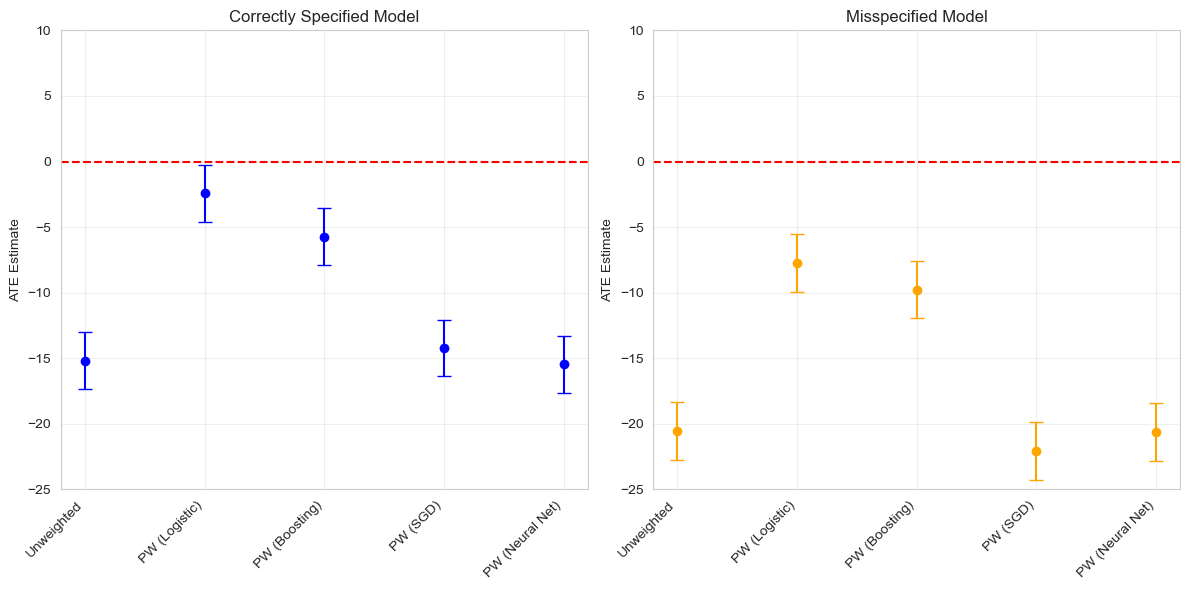

In [7]:
# Plot ATEs
plt.figure(figsize=(12, 6))

# Plot correctly specified model results
plt.subplot(1, 2, 1)
correct_df = results_df[results_df['Misspecified'] == False]
plt.errorbar(
    correct_df['Method'], 
    correct_df['ATE'], 
    yerr=correct_df['SE'], 
    fmt='o', 
    capsize=5, 
    color='blue'
)
plt.axhline(y=0, color='r', linestyle='--', label='True ATE')
plt.xticks(rotation=45, ha='right')
plt.title('Correctly Specified Model')
plt.ylabel('ATE Estimate')
plt.ylim(-25, 10)
plt.grid(True, alpha=0.3)

# Plot misspecified model results
plt.subplot(1, 2, 2)
mis_df = results_df[results_df['Misspecified'] == True]
plt.errorbar(
    mis_df['Method'], 
    mis_df['ATE'], 
    yerr=mis_df['SE'], 
    fmt='o', 
    capsize=5, 
    color='orange'
)
plt.axhline(y=0, color='r', linestyle='--', label='True ATE')
plt.xticks(rotation=45, ha='right')
plt.title('Misspecified Model')
plt.ylabel('ATE Estimate')
plt.ylim(-25, 10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Examine Weight Distributions

Let's look at the distributions of weights from different methods.

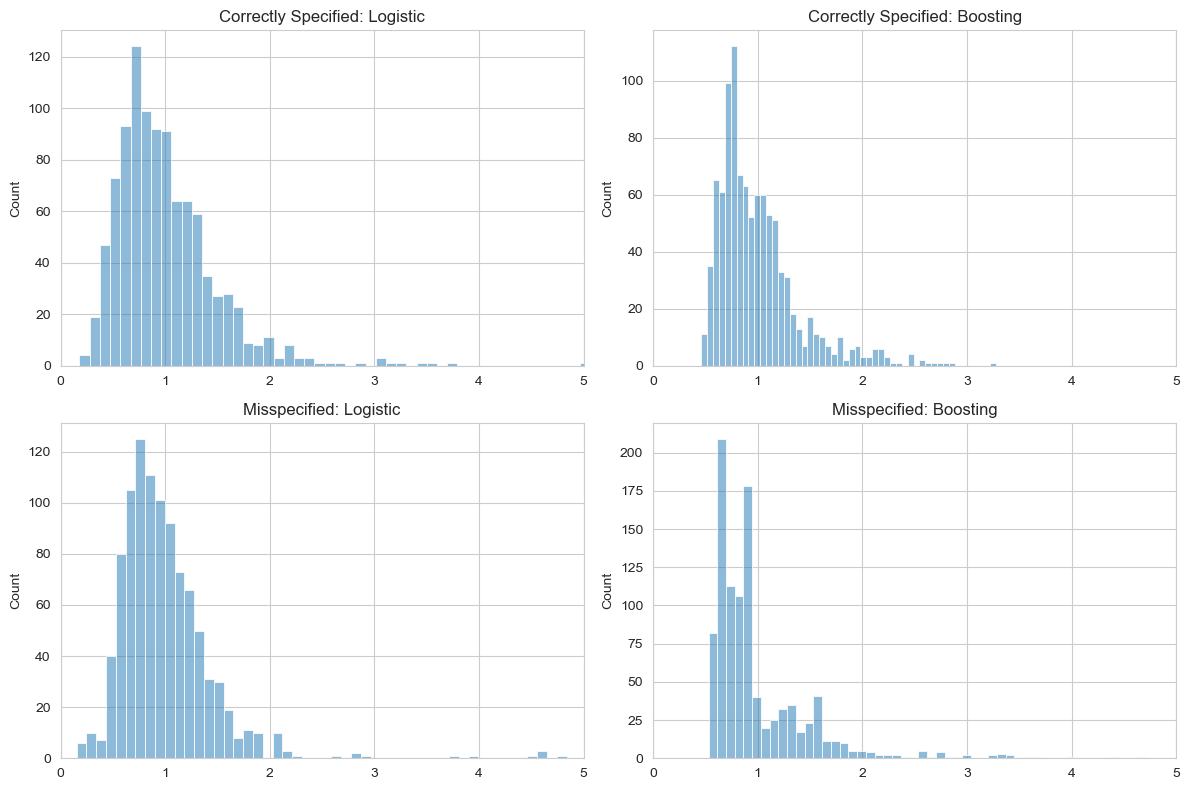

In [8]:
plt.figure(figsize=(12, 8))

# Plot weight distributions for correctly specified model
plt.subplot(2, 2, 1)
sns.histplot(pw_logit['weights'], bins=50, alpha=0.5, label='Logistic')
plt.xlim(0, 5)
plt.title('Correctly Specified: Logistic')

plt.subplot(2, 2, 2)
sns.histplot(pw_boost['weights'], bins=50, alpha=0.5, label='Boosting')
plt.xlim(0, 5)
plt.title('Correctly Specified: Boosting')

# Plot weight distributions for misspecified model
plt.subplot(2, 2, 3)
sns.histplot(pw_logit_mis['weights'], bins=50, alpha=0.5, label='Logistic')
plt.xlim(0, 5)
plt.title('Misspecified: Logistic')

plt.subplot(2, 2, 4)
sns.histplot(pw_boost_mis['weights'], bins=50, alpha=0.5, label='Boosting')
plt.xlim(0, 5)
plt.title('Misspecified: Boosting')

plt.tight_layout()
plt.show()

## Compare Balance Metrics

Let's look at the balance metrics (MSE and LogLoss) for different methods.

In [9]:
# Extract balance metrics
balance_metrics = []

# Correctly specified model
balance_metrics.append({
    'Method': 'PW (Logistic)',
    'Misspecified': False,
    'MSE': pw_logit['train']['MSEEvaluator'],
    'LogLoss': pw_logit['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (Boosting)',
    'Misspecified': False,
    'MSE': pw_boost['train']['MSEEvaluator'],
    'LogLoss': pw_boost['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (SGD)',
    'Misspecified': False,
    'MSE': pw_sgd['train']['MSEEvaluator'],
    'LogLoss': pw_sgd['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (Neural Net)',
    'Misspecified': False,
    'MSE': pw_nn['train']['MSEEvaluator'],
    'LogLoss': pw_nn['train']['LogLossEvaluator']
})

# Misspecified model
balance_metrics.append({
    'Method': 'PW (Logistic)',
    'Misspecified': True,
    'MSE': pw_logit_mis['train']['MSEEvaluator'],
    'LogLoss': pw_logit_mis['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (Boosting)',
    'Misspecified': True,
    'MSE': pw_boost_mis['train']['MSEEvaluator'],
    'LogLoss': pw_boost_mis['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (SGD)',
    'Misspecified': True,
    'MSE': pw_sgd_mis['train']['MSEEvaluator'],
    'LogLoss': pw_sgd_mis['train']['LogLossEvaluator']
})

balance_metrics.append({
    'Method': 'PW (Neural Net)',
    'Misspecified': True,
    'MSE': pw_nn_mis['train']['MSEEvaluator'],
    'LogLoss': pw_nn_mis['train']['LogLossEvaluator']
})

# Convert to DataFrame
balance_df = pd.DataFrame(balance_metrics)
balance_df

,Method,Misspecified,MSE,LogLoss
0,PW (Logistic),False,0.309980,0.719614
1,PW (Boosting),False,0.318807,0.689449
2,PW (SGD),False,0.313183,0.713290
3,PW (Neural Net),False,0.314521,0.637356
4,PW (Logistic),True,0.305330,0.722671
5,PW (Boosting),True,0.322390,0.687123
6,PW (SGD),True,0.312758,0.721455
7,PW (Neural Net),True,0.314865,0.640527


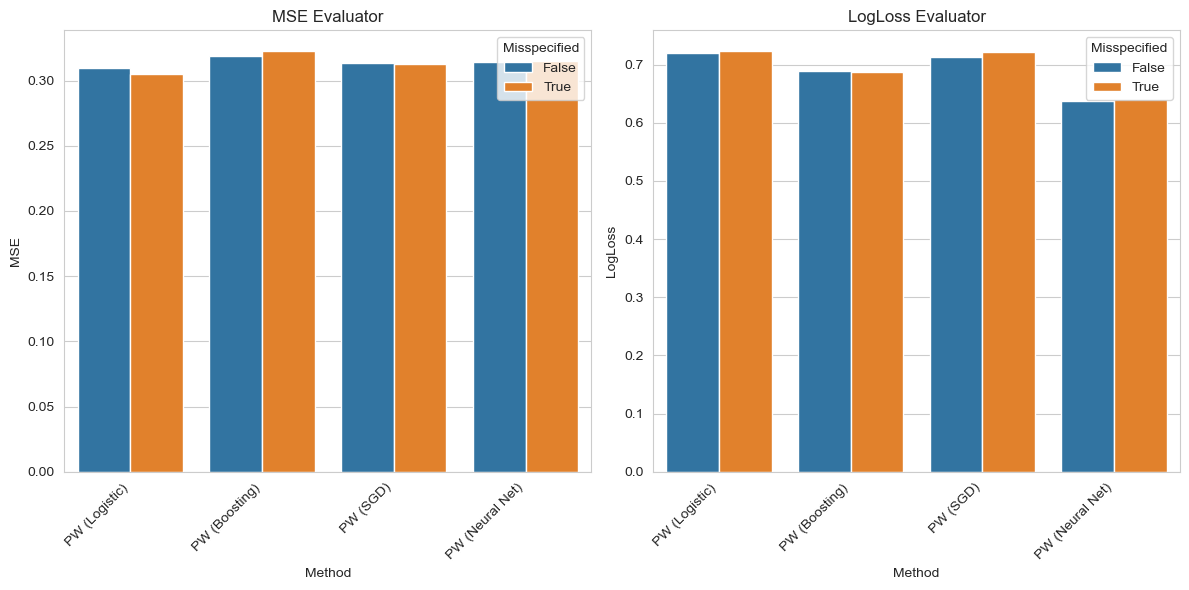

In [10]:
# Plot balance metrics
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
sns.barplot(x='Method', y='MSE', hue='Misspecified', data=balance_df)
plt.xticks(rotation=45, ha='right')
plt.title('MSE Evaluator')
plt.ylabel('MSE')
plt.legend(title='Misspecified')

# Plot LogLoss
plt.subplot(1, 2, 2)
sns.barplot(x='Method', y='LogLoss', hue='Misspecified', data=balance_df)
plt.xticks(rotation=45, ha='right')
plt.title('LogLoss Evaluator')
plt.ylabel('LogLoss')
plt.legend(title='Misspecified')

plt.tight_layout()
plt.show()